# Investigating ECCO heat and salt transport in the CTF

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import scipy.stats
import sys
sys.path.append('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/code/GitHub/ECCOv4-py')
import ecco_v4_py as ecco
import datetime
import geopandas
from cartopy.mpl.geoaxes import GeoAxes
import cartopy
from sklearn.metrics import mean_squared_error
import cmocean.cm as cmo
import gsw
import geopy.distance
import cartopy.crs as ccrs
import cartopy.feature as cfeature


from ecco_v4_py.llc_array_conversion import llc_tiles_to_xda



ec_col = '#2ca1db' # eastern carib
cc_col = '#f44323' # central carib
wc_col = '#112047' # western carib


## Load data

In [2]:
## Load grid
ecco_grid = xr.open_dataset('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/ECCO/ECCO_L4_GEOMETRY_LLC0090GRID_V4R4/GRID_GEOMETRY_ECCO_V4r4_native_llc0090.nc')

In [5]:
## Load ECCO velocity variables
fnames = glob.glob('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/ECCO/ECCO_L4_OCEAN_3D_VOLUME_FLUX_LLC0090GRID_MONTHLY_V4R4/*.nc')
ecco_vars_uvw = xr.open_mfdataset(fnames,data_vars='minimal',coords='minimal',compat='override')

In [6]:
## Load ECCO temperature variables
fnames = glob.glob('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/ECCO/ECCO_L4_OCEAN_3D_TEMPERATURE_FLUX_LLC0090GRID_MONTHLY_V4R4/*.nc')
ecco_vars_adv_th = xr.open_mfdataset(fnames,data_vars='minimal',coords='minimal',compat='override')

In [7]:
## Load ECCO salt variables
fnames = glob.glob('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/ECCO/ECCO_L4_OCEAN_3D_SALINITY_FLUX_LLC0090GRID_MONTHLY_V4R4/*.nc')
ecco_vars_adv_slt = xr.open_mfdataset(fnames,data_vars='minimal',coords='minimal',compat='override')

In [8]:
## Load ECCO hydrographic data
fnames = glob.glob('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/ECCO/ECCO_L4_TEMP_SALINITY_LLC0090GRID_MONTHLY_V4R4/*.nc')
ts = xr.open_mfdataset(fnames, data_vars='minimal', coords='minimal', compat='override')

pressure = gsw.p_from_z(ts.Z,ts.j)
ts['absolute_salinity'] = gsw.SA_from_SP(ts.SALT, pressure, ts.i, ts.j)    
ts['conservative_temperature'] = gsw.CT_from_pt(ts.absolute_salinity, ts.THETA)
ts['potential_density'] = gsw.sigma0(ts.absolute_salinity, ts.conservative_temperature)+1000

In [9]:
## Subset and combine
ecco_vars = xr.merge((ecco_vars_adv_th[['ADVx_TH','ADVy_TH','DFxE_TH','DFyE_TH']],ecco_vars_adv_slt[['ADVx_SLT','ADVy_SLT','DFxE_SLT','DFyE_SLT']],ecco_vars_uvw[['UVELMASS','VVELMASS']],ts[['absolute_salinity','conservative_temperature','potential_density']]))
## Merge the ecco_grid with the ecco_vars to make the ecco_ds
ds = xr.merge((ecco_grid, ecco_vars))

## Sections

In [10]:
# Cancun to Cuba (Yucatan Straits)
#yucatan_pt1 = [-84, 22] # not bad but want to get cells further south
yucatan_pt1 = [-82, 22]
yucatan_pt2 = [-87.5, 19.8]

# Cuba to Haiti (Windward Passage)
windward_pt1 = [-73.2, 19.6]
windward_pt2 = [-74.8, 20.1]

# 69W line
central_pt1 = [-69.75, 11.3]
central_pt2 = [-69.75, 18.4]

# Florida Straits
pt1, pt2 = ecco.get_section_endpoints('Florida Strait')
maskC_fs, maskW_fs, maskS_fs = ecco.get_section_line_masks(pt1,pt2,ds)

maskC_yucatan, maskW_yucatan, maskS_yucatan = ecco.get_section_line_masks(yucatan_pt1,yucatan_pt2,ds)
maskC_windward, maskW_windward, maskS_windward = ecco.get_section_line_masks(windward_pt1,windward_pt2,ds)
maskC_central, maskW_central, maskS_central = ecco.get_section_line_masks(central_pt1,central_pt2,ds)

maskC_tot = (maskC_yucatan+maskC_windward+maskC_central+maskC_fs).where(maskC_yucatan+maskC_windward+maskC_central+maskC_fs==1,0)
maskW_tot = (maskW_yucatan+maskW_windward+maskW_central+maskW_fs).where(maskW_yucatan+maskW_windward+maskW_central+maskW_fs==1,0)
maskS_tot = (maskS_yucatan+maskS_windward+maskS_central+maskS_fs).where(maskS_yucatan+maskS_windward+maskS_central+maskS_fs==1,0)

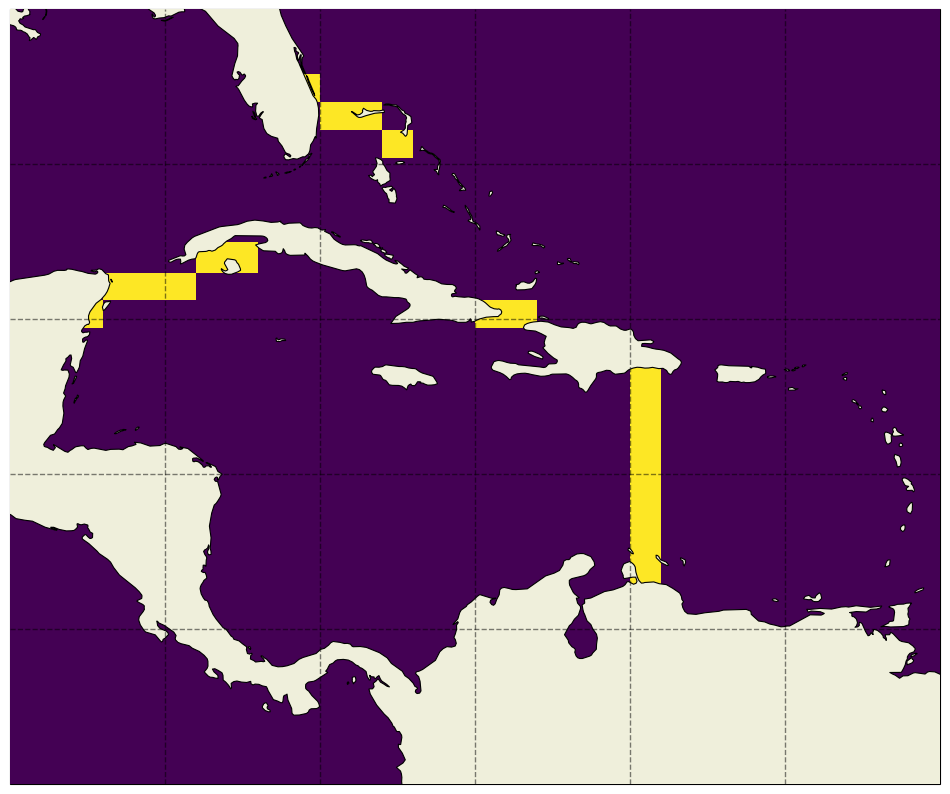

In [11]:
plt.figure(figsize=(12,12))
# use dx=.1, dy=.1 so that plot shows the osnap array as a thin
# line.  remember, plot_proj_to_latlon_grid first interpolates
# the model grid to lat-lon with grid spacing as dx, dy
P = ecco.plot_proj_to_latlon_grid(ds.XC, ds.YC, maskC_tot, \
                                cmap='viridis',\
                                projection_type='PlateCarree',\
                                lat_lim=45,dx=.1,dy=.1)
#ax.add_feature(cart.feature.LAND,facecolor='0.7',zorder=2)
P[1].set_extent([-90, -60, 5, 30], crs=ccrs.PlateCarree())
plt.show()

In [31]:
sw_t = ds.where(ds.potential_density<1024)
iw_t = ds.where((ds.potential_density>1024)&(ds.potential_density<1027))
dw_t = ds.where((ds.potential_density>1027))

## Transport in isopycnal classes

In [15]:
## Volume transport
yucatan_vol_transport_sw = ecco.calc_section_vol_trsp(sw_t,pt1= yucatan_pt1, pt2=yucatan_pt2)
central_vol_transport_sw = ecco.calc_section_vol_trsp(sw_t,pt1= central_pt1, pt2=central_pt2)
windward_vol_transport_sw = ecco.calc_section_vol_trsp(sw_t,pt1= windward_pt1, pt2=windward_pt2)
fs_vol_transport_sw = ecco.calc_section_vol_trsp(sw_t,section_name='Florida Strait')

yucatan_vol_transport_iw = ecco.calc_section_vol_trsp(iw_t,pt1= yucatan_pt1, pt2=yucatan_pt2)
central_vol_transport_iw = ecco.calc_section_vol_trsp(iw_t,pt1= central_pt1, pt2=central_pt2)
windward_vol_transport_iw = ecco.calc_section_vol_trsp(iw_t,pt1= windward_pt1, pt2=windward_pt2)
fs_vol_transport_iw = ecco.calc_section_vol_trsp(iw_t,section_name='Florida Strait')

yucatan_vol_transport_dw = ecco.calc_section_vol_trsp(dw_t,pt1= yucatan_pt1, pt2=yucatan_pt2)
central_vol_transport_dw = ecco.calc_section_vol_trsp(dw_t,pt1= central_pt1, pt2=central_pt2)
windward_vol_transport_dw = ecco.calc_section_vol_trsp(dw_t,pt1= windward_pt1, pt2=windward_pt2)
fs_vol_transport_dw = ecco.calc_section_vol_trsp(dw_t,section_name='Florida Strait')

## Heat transport
yucatan_heat_transport_sw = ecco.calc_section_heat_trsp(sw_t,pt1= yucatan_pt1, pt2=yucatan_pt2)
central_heat_transport_sw = ecco.calc_section_heat_trsp(sw_t,pt1= central_pt1, pt2=central_pt2)
windward_heat_transport_sw = ecco.calc_section_heat_trsp(sw_t,pt1= windward_pt1, pt2=windward_pt2)
fs_heat_transport_sw = ecco.calc_section_heat_trsp(sw_t,section_name='Florida Strait')

yucatan_heat_transport_iw = ecco.calc_section_heat_trsp(iw_t,pt1= yucatan_pt1, pt2=yucatan_pt2)
central_heat_transport_iw = ecco.calc_section_heat_trsp(iw_t,pt1= central_pt1, pt2=central_pt2)
windward_heat_transport_iw = ecco.calc_section_heat_trsp(iw_t,pt1= windward_pt1, pt2=windward_pt2)
fs_heat_transport_iw = ecco.calc_section_heat_trsp(iw_t,section_name='Florida Strait')

yucatan_heat_transport_dw = ecco.calc_section_heat_trsp(dw_t,pt1= yucatan_pt1, pt2=yucatan_pt2)
central_heat_transport_dw = ecco.calc_section_heat_trsp(dw_t,pt1= central_pt1, pt2=central_pt2)
windward_heat_transport_dw = ecco.calc_section_heat_trsp(dw_t,pt1= windward_pt1, pt2=windward_pt2)
fs_heat_transport_dw = ecco.calc_section_heat_trsp(dw_t,section_name='Florida Strait')

## Salt transport
yucatan_salt_transport_sw = ecco.calc_section_salt_trsp(sw_t,pt1= yucatan_pt1, pt2=yucatan_pt2)
central_salt_transport_sw = ecco.calc_section_salt_trsp(sw_t,pt1= central_pt1, pt2=central_pt2)
windward_salt_transport_sw = ecco.calc_section_salt_trsp(sw_t,pt1= windward_pt1, pt2=windward_pt2)
fs_salt_transport_sw = ecco.calc_section_salt_trsp(sw_t,section_name='Florida Strait')

yucatan_salt_transport_iw = ecco.calc_section_salt_trsp(iw_t,pt1= yucatan_pt1, pt2=yucatan_pt2)
central_salt_transport_iw = ecco.calc_section_salt_trsp(iw_t,pt1= central_pt1, pt2=central_pt2)
windward_salt_transport_iw = ecco.calc_section_salt_trsp(iw_t,pt1= windward_pt1, pt2=windward_pt2)
fs_salt_transport_iw = ecco.calc_section_salt_trsp(iw_t,section_name='Florida Strait')

yucatan_salt_transport_dw = ecco.calc_section_salt_trsp(dw_t,pt1= yucatan_pt1, pt2=yucatan_pt2)
central_salt_transport_dw = ecco.calc_section_salt_trsp(dw_t,pt1= central_pt1, pt2=central_pt2)
windward_salt_transport_dw = ecco.calc_section_salt_trsp(dw_t,pt1= windward_pt1, pt2=windward_pt2)
fs_salt_transport_dw = ecco.calc_section_salt_trsp(dw_t,section_name='Florida Strait')

## Save datasets so I don't have to deal with rerunning/dask again

In [20]:
yucatan_vol_transport_sw.to_netcdf('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/ECCO/Section_Vol_Heat_Salt_Transports/isopycnal/ECCO_2005_2017_Yucatan_Straits_Volume_Transport_SW.nc')
yucatan_heat_transport_sw.to_netcdf('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/ECCO/Section_Vol_Heat_Salt_Transports/isopycnal/ECCO_2005_2017_Yucatan_Straits_Heat_Transport_SW.nc')
yucatan_salt_transport_sw.to_netcdf('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/ECCO/Section_Vol_Heat_Salt_Transports/isopycnal/ECCO_2005_2017_Yucatan_Straits_Salt_Transport_SW.nc')
yucatan_vol_transport_iw.to_netcdf('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/ECCO/Section_Vol_Heat_Salt_Transports/isopycnal/ECCO_2005_2017_Yucatan_Straits_Volume_Transport_IW.nc')
yucatan_heat_transport_iw.to_netcdf('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/ECCO/Section_Vol_Heat_Salt_Transports/isopycnal/ECCO_2005_2017_Yucatan_Straits_Heat_Transport_IW.nc')
yucatan_salt_transport_iw.to_netcdf('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/ECCO/Section_Vol_Heat_Salt_Transports/isopycnal/ECCO_2005_2017_Yucatan_Straits_Salt_Transport_IW.nc')
yucatan_vol_transport_dw.to_netcdf('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/ECCO/Section_Vol_Heat_Salt_Transports/isopycnal/ECCO_2005_2017_Yucatan_Straits_Volume_Transport_DW.nc')
yucatan_heat_transport_dw.to_netcdf('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/ECCO/Section_Vol_Heat_Salt_Transports/isopycnal/ECCO_2005_2017_Yucatan_Straits_Heat_Transport_DW.nc')
yucatan_salt_transport_dw.to_netcdf('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/ECCO/Section_Vol_Heat_Salt_Transports/isopycnal/ECCO_2005_2017_Yucatan_Straits_Salt_Transport_DW.nc')

windward_vol_transport_sw.to_netcdf('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/ECCO/Section_Vol_Heat_Salt_Transports/isopycnal/ECCO_2005_2017_Windward_Passage_Volume_Transport_SW.nc')
windward_heat_transport_sw.to_netcdf('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/ECCO/Section_Vol_Heat_Salt_Transports/isopycnal/ECCO_2005_2017_Windward_Passage_Heat_Transport_SW.nc')
windward_salt_transport_sw.to_netcdf('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/ECCO/Section_Vol_Heat_Salt_Transports/isopycnal/ECCO_2005_2017_Windward_Passage_Salt_Transport_SW.nc')
windward_vol_transport_iw.to_netcdf('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/ECCO/Section_Vol_Heat_Salt_Transports/isopycnal/ECCO_2005_2017_Windward_Passage_Volume_Transport_IW.nc')
windward_heat_transport_iw.to_netcdf('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/ECCO/Section_Vol_Heat_Salt_Transports/isopycnal/ECCO_2005_2017_Windward_Passage_Heat_Transport_IW.nc')
windward_salt_transport_iw.to_netcdf('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/ECCO/Section_Vol_Heat_Salt_Transports/isopycnal/ECCO_2005_2017_Windward_Passage_Salt_Transport_IW.nc')
windward_vol_transport_dw.to_netcdf('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/ECCO/Section_Vol_Heat_Salt_Transports/isopycnal/ECCO_2005_2017_Windward_Passage_Volume_Transport_DW.nc')
windward_heat_transport_dw.to_netcdf('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/ECCO/Section_Vol_Heat_Salt_Transports/isopycnal/ECCO_2005_2017_Windward_Passage_Heat_Transport_DW.nc')
windward_salt_transport_dw.to_netcdf('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/ECCO/Section_Vol_Heat_Salt_Transports/isopycnal/ECCO_2005_2017_Windward_Passage_Salt_Transport_DW.nc')

central_vol_transport_sw.to_netcdf('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/ECCO/Section_Vol_Heat_Salt_Transports/isopycnal/ECCO_2005_2017_69W_Volume_Transport_SW.nc')
central_heat_transport_sw.to_netcdf('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/ECCO/Section_Vol_Heat_Salt_Transports/isopycnal/ECCO_2005_2017_69W_Heat_Transport_SW.nc')
central_salt_transport_sw.to_netcdf('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/ECCO/Section_Vol_Heat_Salt_Transports/isopycnal/ECCO_2005_2017_69W_Salt_Transport_SW.nc')
central_vol_transport_iw.to_netcdf('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/ECCO/Section_Vol_Heat_Salt_Transports/isopycnal/ECCO_2005_2017_69W_Volume_Transport_IW.nc')
central_heat_transport_iw.to_netcdf('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/ECCO/Section_Vol_Heat_Salt_Transports/isopycnal/ECCO_2005_2017_69W_Heat_Transport_IW.nc')
central_salt_transport_iw.to_netcdf('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/ECCO/Section_Vol_Heat_Salt_Transports/isopycnal/ECCO_2005_2017_69W_Salt_Transport_IW.nc')
central_vol_transport_dw.to_netcdf('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/ECCO/Section_Vol_Heat_Salt_Transports/isopycnal/ECCO_2005_2017_69W_Volume_Transport_DW.nc')
central_heat_transport_dw.to_netcdf('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/ECCO/Section_Vol_Heat_Salt_Transports/isopycnal/ECCO_2005_2017_69W_Heat_Transport_DW.nc')
central_salt_transport_dw.to_netcdf('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/ECCO/Section_Vol_Heat_Salt_Transports/isopycnal/ECCO_2005_2017_69W_Salt_Transport_DW.nc')

fs_vol_transport_sw.to_netcdf('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/ECCO/Section_Vol_Heat_Salt_Transports/isopycnal/ECCO_2005_2017_FS_Volume_Transport_SW.nc')
fs_heat_transport_sw.to_netcdf('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/ECCO/Section_Vol_Heat_Salt_Transports/isopycnal/ECCO_2005_2017_FS_Heat_Transport_SW.nc')
fs_salt_transport_sw.to_netcdf('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/ECCO/Section_Vol_Heat_Salt_Transports/isopycnal/ECCO_2005_2017_FS_Salt_Transport_SW.nc')
fs_vol_transport_iw.to_netcdf('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/ECCO/Section_Vol_Heat_Salt_Transports/isopycnal/ECCO_2005_2017_FS_Volume_Transport_IW.nc')
fs_heat_transport_iw.to_netcdf('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/ECCO/Section_Vol_Heat_Salt_Transports/isopycnal/ECCO_2005_2017_FS_Heat_Transport_IW.nc')
fs_salt_transport_iw.to_netcdf('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/ECCO/Section_Vol_Heat_Salt_Transports/isopycnal/ECCO_2005_2017_FS_Salt_Transport_IW.nc')
fs_vol_transport_dw.to_netcdf('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/ECCO/Section_Vol_Heat_Salt_Transports/isopycnal/ECCO_2005_2017_FS_Volume_Transport_DW.nc')
fs_heat_transport_dw.to_netcdf('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/ECCO/Section_Vol_Heat_Salt_Transports/isopycnal/ECCO_2005_2017_FS_Heat_Transport_DW.nc')
fs_salt_transport_dw.to_netcdf('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/ECCO/Section_Vol_Heat_Salt_Transports/isopycnal/ECCO_2005_2017_FS_Salt_Transport_DW.nc')


KeyboardInterrupt



In [22]:
ds

<xarray.Dataset>
Dimensions:                   (i: 90, i_g: 90, j: 90, j_g: 90, k: 50, k_u: 50,
                               k_l: 50, k_p1: 51, tile: 13, nb: 4, nv: 2,
                               time: 4748)
Coordinates: (12/21)
  * i                         (i) int32 0 1 2 3 4 5 6 7 ... 83 84 85 86 87 88 89
  * i_g                       (i_g) int32 0 1 2 3 4 5 6 ... 83 84 85 86 87 88 89
  * j                         (j) int32 0 1 2 3 4 5 6 7 ... 83 84 85 86 87 88 89
  * j_g                       (j_g) int32 0 1 2 3 4 5 6 ... 83 84 85 86 87 88 89
  * k                         (k) int32 0 1 2 3 4 5 6 7 ... 43 44 45 46 47 48 49
  * k_u                       (k_u) int32 0 1 2 3 4 5 6 ... 43 44 45 46 47 48 49
    ...                        ...
    Zu                        (k_u) float32 ...
    Zl                        (k_l) float32 ...
    XC_bnds                   (tile, j, i, nb) float32 ...
    YC_bnds                   (tile, j, i, nb) float32 ...
    Z_bnds                    (k, nv) float32 ...
  * time                      (time) datetime64[ns] 2005-01-01T12:00:00 ... 2...
Dimensions without coordinates: nb, nv
Data variables: (12/34)
    CS                        (tile, j, i) float32 0.06158 0.06675 ... -0.9984
    SN                        (tile, j, i) float32 -0.9981 -0.9978 ... -0.05718
    rA                        (tile, j, i) float32 3.623e+08 ... 3.611e+08
    dxG                       (tile, j_g, i) float32 1.558e+04 ... 2.314e+04
    dyG                       (tile, j, i_g) float32 2.321e+04 ... 1.558e+04
    Depth                     (tile, j, i) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    ...                        ...
    DFyE_SLT                  (time, k, tile, j_g, i) float32 dask.array<chunksize=(1, 50, 13, 90, 90), meta=np.ndarray>
    UVELMASS                  (time, k, tile, j, i_g) float32 dask.array<chunksize=(1, 50, 13, 90, 90), meta=np.ndarray>
    VVELMASS                  (time, k, tile, j_g, i) float32 dask.array<chunksize=(1, 50, 13, 90, 90), meta=np.ndarray>
    absolute_salinity         (time, k, tile, j, i) float64 dask.array<chunksize=(1, 50, 13, 90, 90), meta=np.ndarray>
    conservative_temperature  (time, k, tile, j, i) float64 dask.array<chunksize=(1, 50, 13, 90, 90), meta=np.ndarray>
    potential_density         (time, k, tile, j, i) float64 dask.array<chunksize=(1, 50, 13, 90, 90), meta=np.ndarray>
Attributes: (12/58)
    acknowledgement:                 This research was carried out by the Jet...
    author:                          Ian Fenty and Ou Wang
    cdm_data_type:                   Grid
    comment:                         Fields provided on the curvilinear lat-l...
    Conventions:                     CF-1.8, ACDD-1.3
    coordinates_comment:             Note: the global 'coordinates' attribute...
    ...                              ...
    references:                      ECCO Consortium, Fukumori, I., Wang, O.,...
    source:                          The ECCO V4r4 state estimate was produce...
    standard_name_vocabulary:        NetCDF Climate and Forecast (CF) Metadat...
    summary:                         This dataset provides geometric paramete...
    title:                           ECCO Geometry Parameters for the Lat-Lon...
    uuid:                            87ff7d24-86e5-11eb-9c5f-f8f21e2ee3e0

## Transport in depth classes

In [32]:
## Volume transport
yucatan_vol_transport = ecco.calc_section_vol_trsp(ds,pt1= yucatan_pt1, pt2=yucatan_pt2)
central_vol_transport = ecco.calc_section_vol_trsp(ds,pt1= central_pt1, pt2=central_pt2)
windward_vol_transport = ecco.calc_section_vol_trsp(ds,pt1= windward_pt1, pt2=windward_pt2)
fs_vol_transport = ecco.calc_section_vol_trsp(ds,section_name='Florida Strait')

## Heat transport
yucatan_heat_transport = ecco.calc_section_heat_trsp(ds,pt1= yucatan_pt1, pt2=yucatan_pt2)
central_heat_transport = ecco.calc_section_heat_trsp(ds,pt1= central_pt1, pt2=central_pt2)
windward_heat_transport = ecco.calc_section_heat_trsp(ds,pt1= windward_pt1, pt2=windward_pt2)
fs_heat_transport = ecco.calc_section_heat_trsp(ds,section_name='Florida Strait')

## Salt transport
yucatan_salt_transport = ecco.calc_section_salt_trsp(ds,pt1= yucatan_pt1, pt2=yucatan_pt2)
central_salt_transport = ecco.calc_section_salt_trsp(ds,pt1= central_pt1, pt2=central_pt2)
windward_salt_transport = ecco.calc_section_salt_trsp(ds,pt1= windward_pt1, pt2=windward_pt2)
fs_salt_transport = ecco.calc_section_salt_trsp(ds,section_name='Florida Strait')


## Save datasets so I don't have to deal with rerunning/dask again

In [33]:
yucatan_vol_transport.to_netcdf('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/ECCO/Section_Vol_Heat_Salt_Transports/ECCO_2005_2017_Yucatan_Straits_Volume_Transport.nc')
yucatan_heat_transport.to_netcdf('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/ECCO/Section_Vol_Heat_Salt_Transports/ECCO_2005_2017_Yucatan_Straits_Heat_Transport.nc')
yucatan_salt_transport.to_netcdf('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/ECCO/Section_Vol_Heat_Salt_Transports/ECCO_2005_2017_Yucatan_Straits_Salt_Transport.nc')

windward_vol_transport.to_netcdf('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/ECCO/Section_Vol_Heat_Salt_Transports/ECCO_2005_2017_Windward_Passage_Volume_Transport.nc')
windward_heat_transport.to_netcdf('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/ECCO/Section_Vol_Heat_Salt_Transports/ECCO_2005_2017_Windward_Passage_Heat_Transport.nc')
windward_salt_transport.to_netcdf('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/ECCO/Section_Vol_Heat_Salt_Transports/ECCO_2005_2017_Windward_Passage_Salt_Transport.nc')

central_vol_transport.to_netcdf('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/ECCO/Section_Vol_Heat_Salt_Transports/ECCO_2005_2017_69W_Volume_Transport.nc')
central_heat_transport.to_netcdf('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/ECCO/Section_Vol_Heat_Salt_Transports/ECCO_2005_2017_69W_Heat_Transport.nc')
central_salt_transport.to_netcdf('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/ECCO/Section_Vol_Heat_Salt_Transports/ECCO_2005_2017_69W_Salt_Transport.nc')

fs_vol_transport.to_netcdf('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/ECCO/Section_Vol_Heat_Salt_Transports/ECCO_2005_2017_FS_Volume_Transport.nc')
fs_heat_transport.to_netcdf('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/ECCO/Section_Vol_Heat_Salt_Transports/ECCO_2005_2017_FS_Heat_Transport.nc')
fs_salt_transport.to_netcdf('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/ECCO/Section_Vol_Heat_Salt_Transports/ECCO_2005_2017_FS_Salt_Transport.nc')

## Load data

In [34]:
yucatan_ds = xr.open_mfdataset(glob.glob('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/ECCO/Section_Vol_Heat_Salt_Transports/ECCO_2005_2017_Yucatan_Straits*.nc'))
windward_ds = xr.open_mfdataset(glob.glob('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/ECCO/Section_Vol_Heat_Salt_Transports/ECCO_2005_2017_Windward_Passage*.nc'))
central_ds = xr.open_mfdataset(glob.glob('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/ECCO/Section_Vol_Heat_Salt_Transports/ECCO_2005_2017_69W*.nc'))
fs_ds = xr.open_mfdataset(glob.glob('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/ECCO/Section_Vol_Heat_Salt_Transports/ECCO_2005_2017_FS*.nc'))

In [35]:
# yucatan_sw_ds = xr.open_mfdataset(glob.glob('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/ECCO/Section_Vol_Heat_Salt_Transports/ECCO_2005_2017_Yucatan_Straits*SW.nc'))
# windward_sw_ds = xr.open_mfdataset(glob.glob('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/ECCO/Section_Vol_Heat_Salt_Transports/ECCO_2005_2017_Windward_Passage*SW.nc'))
# central_sw_ds = xr.open_mfdataset(glob.glob('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/ECCO/Section_Vol_Heat_Salt_Transports/ECCO_2005_2017_69W*SW.nc'))
# fs_sw_ds = xr.open_mfdataset(glob.glob('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/ECCO/Section_Vol_Heat_Salt_Transports/ECCO_2005_2017_FS*SW.nc'))

# yucatan_iw_ds = xr.open_mfdataset(glob.glob('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/ECCO/Section_Vol_Heat_Salt_Transports/ECCO_2005_2017_Yucatan_Straits*IW.nc'))
# windward_iw_ds = xr.open_mfdataset(glob.glob('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/ECCO/Section_Vol_Heat_Salt_Transports/ECCO_2005_2017_Windward_Passage*IW.nc'))
# central_iw_ds = xr.open_mfdataset(glob.glob('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/ECCO/Section_Vol_Heat_Salt_Transports/ECCO_2005_2017_69W*IW.nc'))
# fs_iw_ds = xr.open_mfdataset(glob.glob('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/ECCO/Section_Vol_Heat_Salt_Transports/ECCO_2005_2017_FS*IW.nc'))

# yucatan_dw_ds = xr.open_mfdataset(glob.glob('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/ECCO/Section_Vol_Heat_Salt_Transports/ECCO_2005_2017_Yucatan_Straits*DW.nc'))
# windward_dw_ds = xr.open_mfdataset(glob.glob('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/ECCO/Section_Vol_Heat_Salt_Transports/ECCO_2005_2017_Windward_Passage*DW.nc'))
# central_dw_ds = xr.open_mfdataset(glob.glob('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/ECCO/Section_Vol_Heat_Salt_Transports/ECCO_2005_2017_69W*DW.nc'))
# fs_dw_ds = xr.open_mfdataset(glob.glob('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/ECCO/Section_Vol_Heat_Salt_Transports/ECCO_2005_2017_FS*DW.nc'))

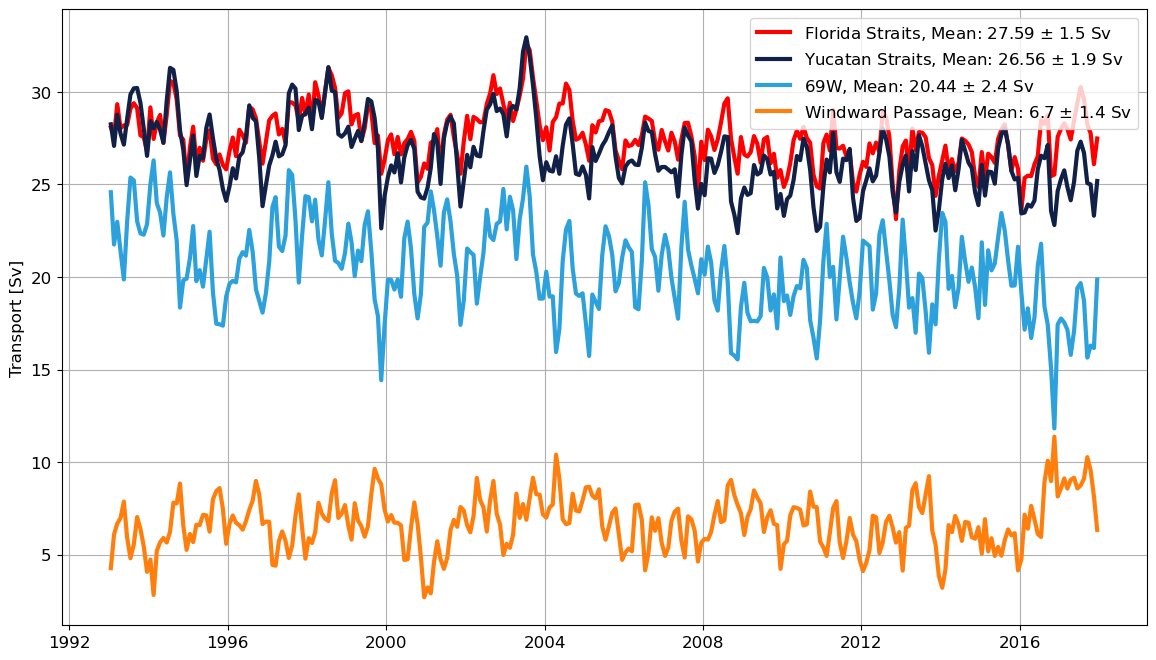

In [36]:
font_size = 12

plt.figure(figsize=(14,8))
plt.plot(fs_ds.time,fs_ds.vol_trsp,label='Florida Straits, Mean: '+str(np.round(fs_ds.vol_trsp.mean().values,2))+ ' $\pm$ '+str(np.round(fs_ds.vol_trsp.std().values,1))+' Sv',linewidth=3,color='Red')
plt.plot(yucatan_ds.time,-yucatan_ds.vol_trsp,label='Yucatan Straits, Mean: '+str(np.round(-yucatan_ds.vol_trsp.mean().values,2))+ ' $\pm$ '+str(np.round(yucatan_ds.vol_trsp.std().values,1))+' Sv',linewidth=3,color=wc_col)
plt.plot(central_ds.time,central_ds.vol_trsp,label='69W, Mean: '+str(np.round(central_ds.vol_trsp.mean().values,2))+ ' $\pm$ '+str(np.round(central_ds.vol_trsp.std().values,1))+' Sv',linewidth=3,color=ec_col)
plt.plot(windward_ds.time,windward_ds.vol_trsp,label='Windward Passage, Mean: '+str(np.round(windward_ds.vol_trsp.mean().values,2))+ ' $\pm$ '+str(np.round(windward_ds.vol_trsp.std().values,1))+' Sv',linewidth=3,color='tab:orange')

plt.legend(fontsize=font_size)
plt.grid()
plt.ylabel('Transport [Sv]',fontsize=font_size)
plt.gca().tick_params(axis='both', which='major', labelsize=font_size)
plt.savefig('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/figures/Python/Model/ECCO/ECCO_FS_Yucatan_Windward_69W_Vol_Transport_Time_Series.png', bbox_inches='tight',dpi=300,facecolor='white')

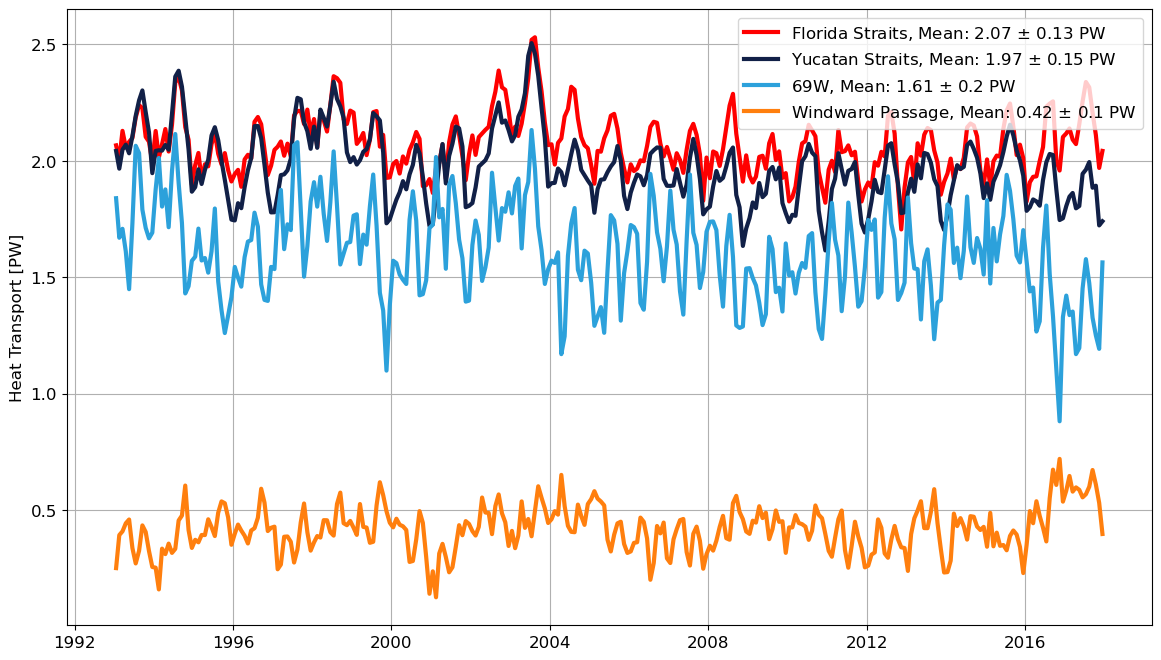

In [37]:
plt.figure(figsize=(14,8))
plt.plot(fs_ds.time,fs_ds.heat_trsp,label='Florida Straits, Mean: '+str(np.round(fs_ds.heat_trsp.mean().values,2))+ ' $\pm$ '+str(np.round(fs_ds.heat_trsp.std().values,2))+' PW',linewidth=3,color='Red')
plt.plot(yucatan_ds.time,-yucatan_ds.heat_trsp,label='Yucatan Straits, Mean: '+str(np.round(-yucatan_ds.heat_trsp.mean().values,2))+' $\pm$ '+str(np.round(yucatan_ds.heat_trsp.std().values,2))+' PW',linewidth=3,color=wc_col)
plt.plot(central_ds.time,central_ds.heat_trsp,label='69W, Mean: '+str(np.round(central_ds.heat_trsp.mean().values,2))+' $\pm$ '+str(np.round(central_ds.heat_trsp.std().values,2))+' PW',linewidth=3,color=ec_col)
plt.plot(windward_ds.time,windward_ds.heat_trsp,label='Windward Passage, Mean: '+str(np.round(windward_ds.heat_trsp.mean().values,2))+' $\pm$ '+str(np.round(windward_ds.heat_trsp.std().values,2))+' PW',linewidth=3,color='tab:orange')
plt.grid()
plt.ylabel('Heat Transport [PW]',fontsize=font_size)
plt.legend(fontsize=font_size)
plt.gca().tick_params(axis='both', which='major', labelsize=font_size)
plt.savefig('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/figures/Python/Model/ECCO/ECCO_FS_Yucatan_Windward_69W_Heat_Transport_Time_Series.png', bbox_inches='tight',dpi=300,facecolor='white')

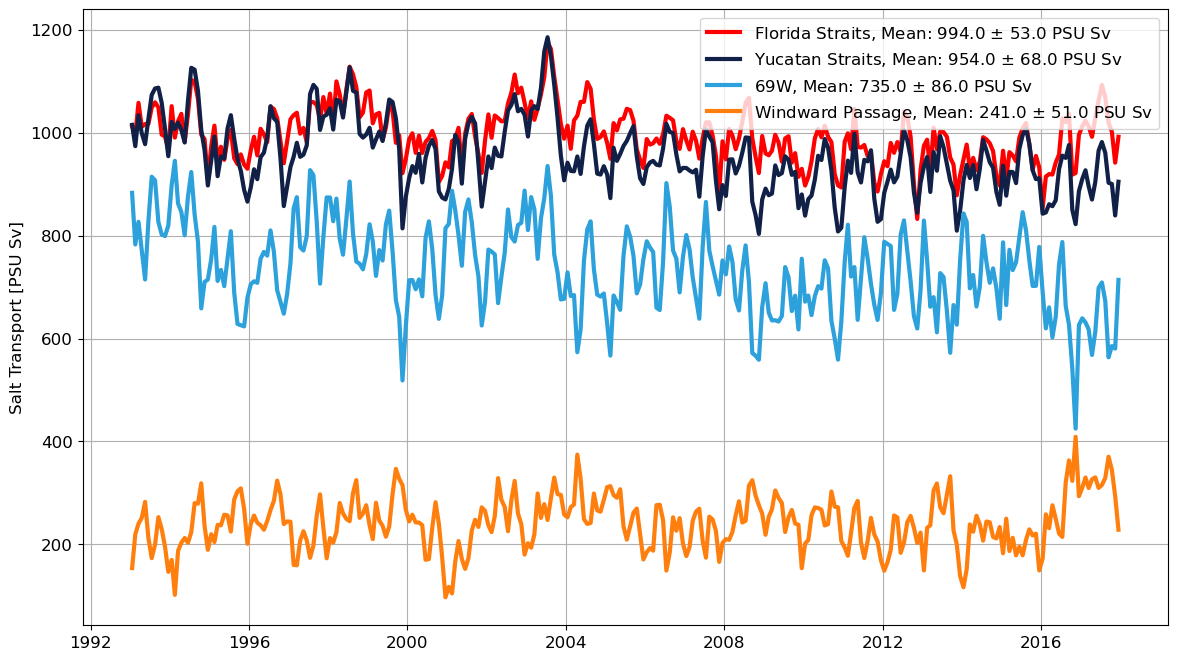

In [38]:
plt.figure(figsize=(14,8))
plt.plot(fs_ds.time,fs_ds.salt_trsp,label='Florida Straits, Mean: '+str(np.round(fs_ds.salt_trsp.mean().values,0))+ ' $\pm$ '+str(np.round(fs_ds.salt_trsp.std().values,0))+' PSU Sv',linewidth=3,color='Red')
plt.plot(yucatan_ds.time,-yucatan_ds.salt_trsp,label='Yucatan Straits, Mean: '+str(np.round(-yucatan_ds.salt_trsp.mean().values,0))+' $\pm$ '+str(np.round(yucatan_ds.salt_trsp.std().values,0))+' PSU Sv',linewidth=3,color=wc_col)
plt.plot(central_ds.time,central_ds.salt_trsp,label='69W, Mean: '+str(np.round(central_ds.salt_trsp.mean().values,0))+' $\pm$ '+str(np.round(central_ds.salt_trsp.std().values,0))+' PSU Sv',linewidth=3,color=ec_col)
plt.plot(windward_ds.time,windward_ds.salt_trsp,label='Windward Passage, Mean: '+str(np.round(windward_ds.salt_trsp.mean().values,0))+' $\pm$ '+str(np.round(windward_ds.salt_trsp.std().values,0))+' PSU Sv',linewidth=3,color='tab:orange')
plt.grid()
plt.ylabel('Salt Transport [PSU Sv]',fontsize=font_size)
plt.legend(fontsize=font_size)
plt.gca().tick_params(axis='both', which='major', labelsize=font_size)

plt.savefig('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/figures/Python/Model/ECCO/ECCO_FS_Yucatan_Windward_69W_Salt_Transport_Time_Series.png', bbox_inches='tight',dpi=300,facecolor='white')

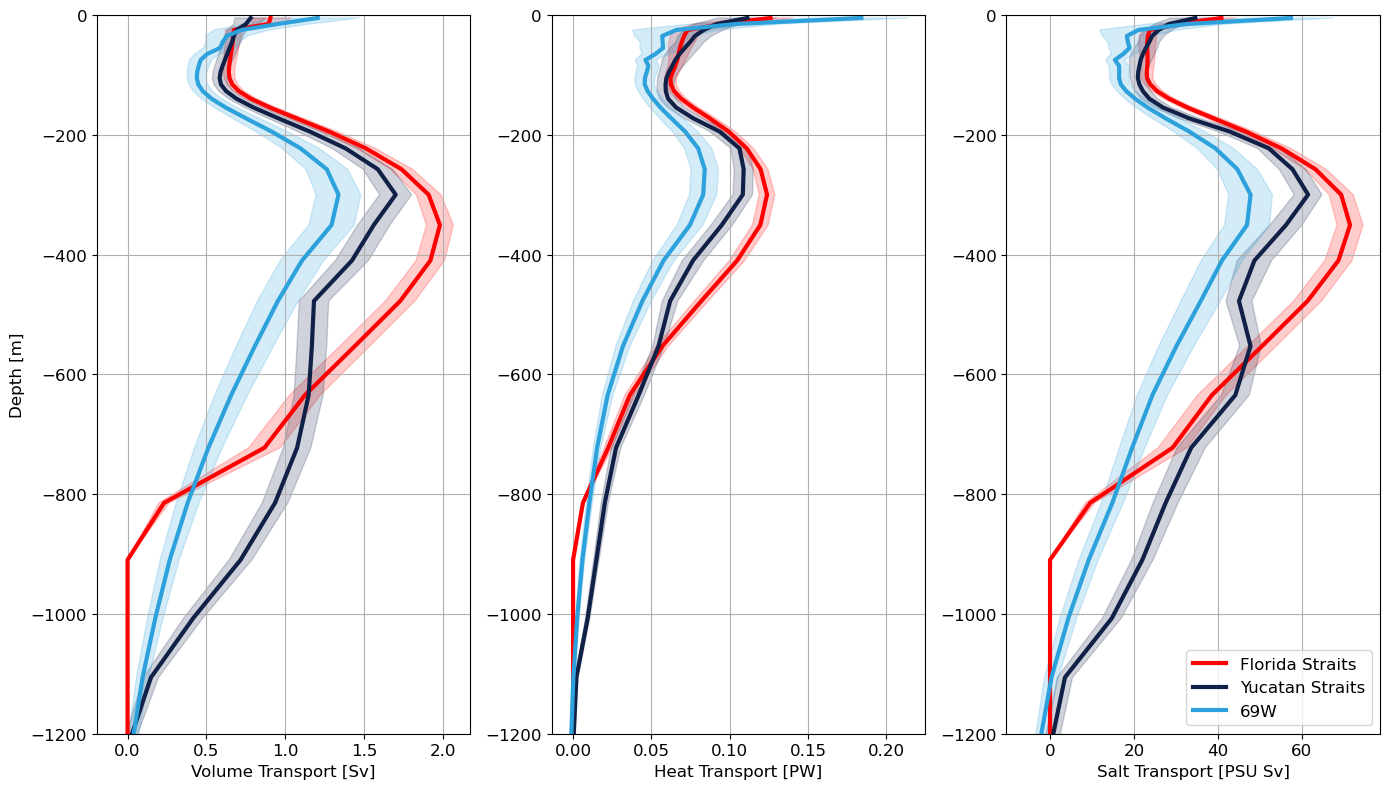

In [39]:
font_size = 12

fig, ax = plt.subplots(1,3,figsize=(14,8))
ax[0].plot(fs_ds.vol_trsp_z.mean(dim='time'),fs_ds.Z,linewidth=3,color='Red')
ax[0].fill_betweenx(fs_ds.Z,fs_ds.vol_trsp_z.mean(dim='time')+fs_ds.vol_trsp_z.std(dim='time'),fs_ds.vol_trsp_z.mean(dim='time')-fs_ds.vol_trsp_z.std(dim='time'),color='Red',alpha=0.2)
ax[0].plot(-yucatan_ds.vol_trsp_z.mean(dim='time'),yucatan_ds.Z,linewidth=3,color=wc_col)
ax[0].fill_betweenx(yucatan_ds.Z,-yucatan_ds.vol_trsp_z.mean(dim='time')+yucatan_ds.vol_trsp_z.std(dim='time'),-yucatan_ds.vol_trsp_z.mean(dim='time')-yucatan_ds.vol_trsp_z.std(dim='time'),color=wc_col,alpha=0.2)
ax[0].plot(central_ds.vol_trsp_z.mean(dim='time'),central_ds.Z,linewidth=3,color=ec_col)
ax[0].fill_betweenx(central_ds.Z,central_ds.vol_trsp_z.mean(dim='time')+central_ds.vol_trsp_z.std(dim='time'),central_ds.vol_trsp_z.mean(dim='time')-central_ds.vol_trsp_z.std(dim='time'),color=ec_col,alpha=0.2)
ax[0].grid()
ax[0].set_ylim(-1200,0)
ax[0].set_xlabel('Volume Transport [Sv]',fontsize=font_size)
ax[0].set_ylabel('Depth [m]',fontsize=font_size)


ax[1].plot(fs_ds.heat_trsp_z.mean(dim='time'),fs_ds.Z,label='69W',linewidth=3,color='Red')
ax[1].fill_betweenx(fs_ds.Z,fs_ds.heat_trsp_z.mean(dim='time')+fs_ds.heat_trsp_z.std(dim='time'),fs_ds.heat_trsp_z.mean(dim='time')-fs_ds.heat_trsp_z.std(dim='time'),color='Red',alpha=0.2)
ax[1].plot(-yucatan_ds.heat_trsp_z.mean(dim='time'),yucatan_ds.Z,label='Yucatan Straits',linewidth=3,color=wc_col)
ax[1].fill_betweenx(yucatan_ds.Z,-yucatan_ds.heat_trsp_z.mean(dim='time')+yucatan_ds.heat_trsp_z.std(dim='time'),-yucatan_ds.heat_trsp_z.mean(dim='time')-yucatan_ds.heat_trsp_z.std(dim='time'),color=wc_col,alpha=0.2)
ax[1].plot(central_ds.heat_trsp_z.mean(dim='time'),central_ds.Z,label='69W',linewidth=3,color=ec_col)
ax[1].fill_betweenx(central_ds.Z,central_ds.heat_trsp_z.mean(dim='time')+central_ds.heat_trsp_z.std(dim='time'),central_ds.heat_trsp_z.mean(dim='time')-central_ds.heat_trsp_z.std(dim='time'),color=ec_col,alpha=0.2)
ax[1].grid()
ax[1].set_ylim(-1200,0)
ax[1].set_xlabel('Heat Transport [PW]',fontsize=font_size)


ax[2].plot(fs_ds.salt_trsp_z.mean(dim='time'),fs_ds.Z,label='Florida Straits',linewidth=3,color='Red')
ax[2].fill_betweenx(fs_ds.Z,fs_ds.salt_trsp_z.mean(dim='time')+fs_ds.salt_trsp_z.std(dim='time'),fs_ds.salt_trsp_z.mean(dim='time')-fs_ds.salt_trsp_z.std(dim='time'),color='Red',alpha=0.2)
ax[2].plot(-yucatan_ds.salt_trsp_z.mean(dim='time'),yucatan_ds.Z,label='Yucatan Straits',linewidth=3,color=wc_col)
ax[2].fill_betweenx(yucatan_ds.Z,-yucatan_ds.salt_trsp_z.mean(dim='time')+yucatan_ds.salt_trsp_z.std(dim='time'),-yucatan_ds.salt_trsp_z.mean(dim='time')-yucatan_ds.salt_trsp_z.std(dim='time'),color=wc_col,alpha=0.2)
ax[2].plot(central_ds.salt_trsp_z.mean(dim='time'),central_ds.Z,label='69W',linewidth=3,color=ec_col)
ax[2].fill_betweenx(central_ds.Z,central_ds.salt_trsp_z.mean(dim='time')+central_ds.salt_trsp_z.std(dim='time'),central_ds.salt_trsp_z.mean(dim='time')-central_ds.salt_trsp_z.std(dim='time'),color=ec_col,alpha=0.2)
ax[2].grid()
ax[2].legend(fontsize=font_size)
ax[2].set_ylim(-1200,0)
ax[2].set_xlabel('Salt Transport [PSU Sv]',fontsize=font_size)


ax[0].tick_params(axis='both', which='major', labelsize=font_size)
ax[1].tick_params(axis='both', which='major', labelsize=font_size)
ax[2].tick_params(axis='both', which='major', labelsize=font_size)

fig.tight_layout()

plt.savefig('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/figures/Python/Model/ECCO/ECCO_FS_Yucatan_69W_Vol_Heat_Salt_Transport_Profiles.png', bbox_inches='tight',dpi=300,facecolor='white')